In [267]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [268]:
%autoreload 2

In [269]:
import re, gc, os, stat
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime as dt
import plotly.graph_objects as go
import plotly

os.chdir('/eos/user/m/mdtoffline/mdt_dcs_offline/streamlit/mdt-dcs-viewer')

from functions import *

# setup pbeast python API

from beauty import Beauty
import libpbeastpy

db = libpbeastpy.ServerProxy('http://pc-tbed-bst-prod:8080')
beauty = Beauty('http://pc-tbed-bst-prod:8080')

pd.options.mode.chained_assignment = None  # default='warn'

In [270]:
%pip install fastparquet

import sys
sys.path.append('/eos/home-i03/m/mdtoffline/.local/lib/python3.9/site-packages')

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [271]:
run_num = 490223

In [272]:
rn_df = beauty.timeseries(dt(2024,4,1,0,0), 
                          dt.now(), 
                          'DCS', 
                          'ATLAS_PVSSDCS', 
                          'value-number', 
                          'ATLGCSDDC:daqRunNumber.value', 
                          None, 
                          False)[0]

rn_df = pd.DataFrame({'value': rn_df.array , 'dt': rn_df.index})
rn_df['dt'] = pd.to_datetime(rn_df['dt'])
rn_df['value'] = rn_df['value'].astype(float).astype(int)
rn_df

value                               dt
0     472017 2024-03-31 17:24:49.911000+02:00
1     472017 2024-04-01 06:03:26.548001+02:00
2     472056 2024-04-01 06:09:05.710000+02:00
3     472056 2024-04-01 18:32:43.958001+02:00
4     472095 2024-04-01 18:40:04.192000+02:00
...      ...                              ...
1749  490490 2024-11-26 11:13:29.899001+01:00
1750  490497 2024-11-26 11:18:09.271000+01:00
1751  490497 2024-11-26 13:31:30.396001+01:00
1752  490516 2024-11-26 13:36:23.743000+01:00
1753  490516 2024-11-26 14:05:53.624001+01:00

[1754 rows x 2 columns]

In [273]:
for i in rn_df['value'].unique():
    
    if rn_df[rn_df['value'] == i].shape[0] != 2:

        rn_df.drop(rn_df[rn_df['value'] == i].index[0], inplace = True)

rn_df

value                               dt
0     472017 2024-03-31 17:24:49.911000+02:00
1     472017 2024-04-01 06:03:26.548001+02:00
2     472056 2024-04-01 06:09:05.710000+02:00
3     472056 2024-04-01 18:32:43.958001+02:00
4     472095 2024-04-01 18:40:04.192000+02:00
...      ...                              ...
1749  490490 2024-11-26 11:13:29.899001+01:00
1750  490497 2024-11-26 11:18:09.271000+01:00
1751  490497 2024-11-26 13:31:30.396001+01:00
1752  490516 2024-11-26 13:36:23.743000+01:00
1753  490516 2024-11-26 14:05:53.624001+01:00

[1684 rows x 2 columns]

In [274]:
total_runs = int(rn_df.shape[0]/2)

In [275]:
sb_df = beauty.timeseries(dt(2024,4,1,0,0), 
                           dt.now(), 
                           'DCS', 
                           'ATLAS_PVSSDCS', 
                           'value-number', 
                           'ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value', 
                           None, 
                           False)[0]

sb_df = pd.DataFrame({'value': sb_df.array , 'dt': sb_df.index})
sb_df['dt'] = pd.to_datetime(sb_df['dt'])
sb_df['value'] = sb_df['value'].astype(float).astype(int)
sb_df

value                               dt
0        1 2024-04-01 09:17:44.416000+02:00
1        0 2024-04-01 15:28:30.552000+02:00
2        1 2024-04-05 18:25:34.679000+02:00
3        0 2024-04-05 23:59:04.802000+02:00
4        1 2024-04-06 02:23:52.855000+02:00
..     ...                              ...
612      0 2024-11-22 10:45:51.245000+01:00
613      1 2024-11-22 13:55:00.316000+01:00
614      0 2024-11-22 17:26:49.398000+01:00
615      1 2024-11-23 03:13:33.614000+01:00
616      0 2024-11-23 06:37:58.690000+01:00

[617 rows x 2 columns]

In [276]:
run_nums = []
run_start_tss = []
run_end_tss = []
sb_start_tss = []
sb_end_tss = []

for tmp_run_num in rn_df['value'].unique():

    tmp_rn_df = rn_df[rn_df['value'] == tmp_run_num]
    
    tmp_run_start_dt = tmp_rn_df.iloc[0]['dt']
    tmp_run_end_dt = tmp_rn_df.iloc[1]['dt']

    tmp_sb_df = sb_df[(sb_df['dt'] > tmp_run_start_dt) & (sb_df['dt'] < tmp_run_end_dt)]

    if len(tmp_sb_df) == 2:

        tmp_sb_start_dt = tmp_sb_df.iloc[0]['dt']
        tmp_sb_end_dt = tmp_sb_df.iloc[1]['dt']
        
        run_nums.append(tmp_run_num)
        run_start_tss.append(tmp_run_start_dt)
        run_end_tss.append(tmp_run_end_dt)
        sb_start_tss.append(tmp_sb_start_dt)
        sb_end_tss.append(tmp_sb_end_dt)

In [277]:
dic_tmp = {'Run Number' : run_nums, 
           'Run Start dt' : run_start_tss, 
           'Run End dt' : run_end_tss,
           'Stable Beam Start dt' : sb_start_tss,
           'Stable Beam End dt' : sb_end_tss
          }

rn_sb_df = pd.DataFrame(dic_tmp)
rn_sb_df = rn_sb_df.iloc[::-1].reset_index(drop=True)

rn_sb_df

Run Number                     Run Start dt  \
0        490223 2024-11-23 01:12:14.146000+01:00   
1        490182 2024-11-22 11:52:09.489000+01:00   
2        490085 2024-11-21 00:41:40.655000+01:00   
3        489961 2024-11-19 23:27:52.540000+01:00   
4        489938 2024-11-19 19:04:37.597000+01:00   
..          ...                              ...   
280      472662 2024-04-07 10:37:52.520000+02:00   
281      472604 2024-04-06 08:46:48.535000+02:00   
282      472578 2024-04-06 01:12:43.331000+02:00   
283      472553 2024-04-05 16:25:05.967000+02:00   
284      472056 2024-04-01 06:09:05.710000+02:00   

                          Run End dt             Stable Beam Start dt  \
0   2024-11-23 19:06:42.440001+01:00 2024-11-23 03:13:33.614000+01:00   
1   2024-11-22 19:45:54.889001+01:00 2024-11-22 13:55:00.316000+01:00   
2   2024-11-21 10:45:33.442001+01:00 2024-11-21 02:33:01.523000+01:00   
3   2024-11-20 08:36:54.382001+01:00 2024-11-20 00:45:10.943000+01:00   
4   2024-11-19 23:20:52.472001+01:00 2024-11-19 21:30:07.870000+01:00   
..                               ...                              ...   
280 2024-04-07 22:01:54.309001+02:00 2024-04-07 11:33:36.596000+02:00   
281 2024-04-06 20:37:33.270001+02:00 2024-04-06 10:00:23.024000+02:00   
282 2024-04-06 08:26:48.183001+02:00 2024-04-06 02:23:52.855000+02:00   
283 2024-04-06 01:06:56.492001+02:00 2024-04-05 18:25:34.679000+02:00   
284 2024-04-01 18:32:43.958001+02:00 2024-04-01 09:17:44.416000+02:00   

                  Stable Beam End dt  
0   2024-11-23 06:37:58.690000+01:00  
1   2024-11-22 17:26:49.398000+01:00  
2   2024-11-21 09:50:45.687000+01:00  
3   2024-11-20 04:40:03.032000+01:00  
4   2024-11-19 22:01:06.881000+01:00  
..                               ...  
280 2024-04-07 19:07:23.761000+02:00  
281 2024-04-06 17:11:43.183000+02:00  
282 2024-04-06 07:25:39.966000+02:00  
283 2024-04-05 23:59:04.802000+02:00  
284 2024-04-01 15:28:30.552000+02:00  

[285 rows x 5 columns]

In [278]:
percentage_of_stable_beam_runs = round(len(rn_sb_df) / total_runs * 100, 2)
print(f"\nPercentage of stable beam runs: {percentage_of_stable_beam_runs}%\n")


Percentage of stable beam runs: 33.85%



In [279]:
run_df = rn_sb_df[rn_sb_df['Run Number'] == run_num]
run_df

Run Number                     Run Start dt  \
0      490223 2024-11-23 01:12:14.146000+01:00   

                        Run End dt             Stable Beam Start dt  \
0 2024-11-23 19:06:42.440001+01:00 2024-11-23 03:13:33.614000+01:00   

                Stable Beam End dt  
0 2024-11-23 06:37:58.690000+01:00

In [280]:
since_dt = run_df.iloc[0]['Run Start dt']
till_dt = run_df.iloc[0]['Run End dt']
sb_start_dt = run_df.iloc[0]['Stable Beam Start dt']
sb_end_dt = run_df.iloc[0]['Stable Beam End dt']
print(since_dt)
print(till_dt)

2024-11-23 01:12:14.146000+01:00
2024-11-23 19:06:42.440001+01:00


In [281]:
def to_ts(dt):

    return int(int(dt.asm8) / 10**3)

In [282]:
temp_sensors_df = db.get_data('DCS', 
                              'ATLAS_PVSSMDT', 
                              'value-number', 
                              '.*.ntc.*', 
                              True, 
                              to_ts(since_dt), 
                              to_ts(till_dt), 
                              0, 
                              True)

temp_sensors_df = queryDataToDataFrame(temp_sensors_df)
temp_sensors_df.sort_values(by=['ts'], inplace=True)
temp_sensors_df['dt'] = pd.to_datetime(temp_sensors_df['ts'], unit = 'us', utc = True).dt.tz_convert('Europe/Zurich')
temp_sensors_df['value'] = temp_sensors_df['value'].astype('float64')
temp_sensors_df['Sensor'] = temp_sensors_df['datapoint'].apply(lambda x : x.split('.')[-2]).apply(lambda x : list(x)[-2:]).apply(lambda x : int(''.join(x)))

In [283]:
temp_sensors_df

datapoint                ts      value  \
87678  ATLMDTMDM4:BIX7A04.ntc.ntc07.value  1732320690153000     25.548   
87652  ATLMDTMDM4:BIX7A04.ntc.ntc04.value  1732320690153000     28.486   
87661  ATLMDTMDM4:BIX7A04.ntc.ntc05.value  1732320690153000     28.632   
89045  ATLMDTMDM4:EOL2A03.ntc.ntc04.value  1732320690325000  16754.800   
91362  ATLMDTMDM4:EOL3A09.ntc.ntc01.value  1732320690385000  16663.300   
...                                   ...               ...        ...   
41776  ATLMDTMDM2:BMS2C02.ntc.ntc07.value  1732385240365000     23.440   
43857  ATLMDTMDM2:BMS4A10.ntc.ntc04.value  1732385240501000      0.000   
45983  ATLMDTMDM2:BMS5C08.ntc.ntc08.value  1732385240606000  16662.100   
47369  ATLMDTMDM2:BMS6C04.ntc.ntc05.value  1732385240668000     24.543   
47709  ATLMDTMDM2:BMS6C16.ntc.ntc03.value  1732385240692000     23.196   

                                    dt  Sensor  
87678 2024-11-23 01:11:30.153000+01:00       7  
87652 2024-11-23 01:11:30.153000+01:00       4  
87661 2024-11-23 01:11:30.153000+01:00       5  
89045 2024-11-23 01:11:30.325000+01:00       4  
91362 2024-11-23 01:11:30.385000+01:00       1  
...                                ...     ...  
41776 2024-11-23 19:07:20.365000+01:00       7  
43857 2024-11-23 19:07:20.501000+01:00       4  
45983 2024-11-23 19:07:20.606000+01:00       8  
47369 2024-11-23 19:07:20.668000+01:00       5  
47709 2024-11-23 19:07:20.692000+01:00       3  

[110963 rows x 5 columns]

In [284]:
temp_sensors_df['chamber'] = temp_sensors_df['datapoint'].apply(lambda x : x.split(':')[1][:7])

In [285]:
temp_sensors_df

datapoint                ts      value  \
87678  ATLMDTMDM4:BIX7A04.ntc.ntc07.value  1732320690153000     25.548   
87652  ATLMDTMDM4:BIX7A04.ntc.ntc04.value  1732320690153000     28.486   
87661  ATLMDTMDM4:BIX7A04.ntc.ntc05.value  1732320690153000     28.632   
89045  ATLMDTMDM4:EOL2A03.ntc.ntc04.value  1732320690325000  16754.800   
91362  ATLMDTMDM4:EOL3A09.ntc.ntc01.value  1732320690385000  16663.300   
...                                   ...               ...        ...   
41776  ATLMDTMDM2:BMS2C02.ntc.ntc07.value  1732385240365000     23.440   
43857  ATLMDTMDM2:BMS4A10.ntc.ntc04.value  1732385240501000      0.000   
45983  ATLMDTMDM2:BMS5C08.ntc.ntc08.value  1732385240606000  16662.100   
47369  ATLMDTMDM2:BMS6C04.ntc.ntc05.value  1732385240668000     24.543   
47709  ATLMDTMDM2:BMS6C16.ntc.ntc03.value  1732385240692000     23.196   

                                    dt  Sensor  chamber  
87678 2024-11-23 01:11:30.153000+01:00       7  BIX7A04  
87652 2024-11-23 01:11:30.153000+01:00       4  BIX7A04  
87661 2024-11-23 01:11:30.153000+01:00       5  BIX7A04  
89045 2024-11-23 01:11:30.325000+01:00       4  EOL2A03  
91362 2024-11-23 01:11:30.385000+01:00       1  EOL3A09  
...                                ...     ...      ...  
41776 2024-11-23 19:07:20.365000+01:00       7  BMS2C02  
43857 2024-11-23 19:07:20.501000+01:00       4  BMS4A10  
45983 2024-11-23 19:07:20.606000+01:00       8  BMS5C08  
47369 2024-11-23 19:07:20.668000+01:00       5  BMS6C04  
47709 2024-11-23 19:07:20.692000+01:00       3  BMS6C16  

[110963 rows x 6 columns]

In [324]:
unique_chambers = temp_sensors_df['chamber'].unique()

avg_temps = []
chambers = []
faulty_chambers = []
faulty_sensors = []

for chamber in unique_chambers:

    tmp_df = temp_sensors_df[temp_sensors_df['chamber'] == chamber]

    number_of_sensors = tmp_df['Sensor'].max()

    avg_sensors = []
    
    for sensor in range(1, number_of_sensors + 1):

        tmp_sensor_df = tmp_df[tmp_df['Sensor'] == sensor]

        avg_sensor = tmp_sensor_df['value'].mean()

        if avg_sensor > 100 or avg_sensor == 0.0:

            avg_sensor = np.NaN

            faulty_chambers.append(chamber)
            faulty_sensors.append(sensor)
            
        avg_sensors.append(avg_sensor)

    avg_temp = np.nanmean(avg_sensors)
    
    avg_temps.append(avg_temp)
    chambers.append(chamber)

In [325]:
tmp_dict = {'Chamber' : chambers, 'Average Temperature' : avg_temps}

avg_temp_df = pd.DataFrame(tmp_dict)

tmp_dict = {'Chamber' : faulty_chambers, 'Faulty Sensors' : faulty_sensors}

faulty_temp_sensors_df = pd.DataFrame(tmp_dict)

In [326]:
avg_temp_df

Chamber  Average Temperature
0    BIX7A04            26.609168
1    EOL2A03            23.208537
2    EOL3A09            22.995204
3    EOL4A11            21.991206
4    EOL6A01            22.606121
..       ...                  ...
873  BIL6C07            23.457889
874  BIR5C11            22.665556
875  BIL3A01            22.939106
876  EOS1A04            22.870746
877  BIR6C15            22.697958

[878 rows x 2 columns]

In [327]:
faulty_temp_sensors_df

Chamber  Faulty Sensors
0   EOL2A03               4
1   EOL3A09               1
2   BIL1A01               3
3   BIL6C03               5
4   BIS6C02               9
5   BOL2A09               3
6   BOL2A09              12
7   BOS3A04               3
8   BIS7C02               4
9   BMF2C14              10
10  BMF2C14              11
11  BML2C13               1
12  BML6A07               1
13  BML6A09               3
14  BMS1A06              10
15  BMS5C08               8
16  EOL2A07               7
17  BIL3C09               3
18  BIS1A16               7
19  BIS1A16               8
20  BIS3C12               9
21  BIS5C02               2
22  BIS5C02               3
23  BIS5C02               5
24  BIS6A10               2
25  BOS5A02               4
26  BOS5A16               8
27  BME4A13               1
28  BMF1A14               4
29  BOF1A14               4
30  BMF2C12               4
31  BMS6A10               6
32  BML2A11               5
33  BML3C11               6
34  BMS4A10               4
35  BIL6C09               5
36  BIR1C11               2
37  BIS3A02               7
38  BIS1A10               8
39  BIS6A08               7
40  BIS1C08               9
41  BML6C03               1
42  BIM3A11               2
43  BIS5A10               6
44  BIL5A07               4
45  BML2A03               5

In [328]:
max_temp = np.nanmax(avg_temp_df['Average Temperature'])
min_temp = np.nanmin(avg_temp_df['Average Temperature'])
print(max_temp, min_temp)

26.609167929292926 20.28547777777778


In [329]:
def get_color_from_temp(temp, max_temp, min_temp):

    index = round( ( temp - min_temp ) / ( max_temp - min_temp ) * 14 )

    return index

In [292]:
get_color_from_temp(27.1, max_temp, min_temp)

13

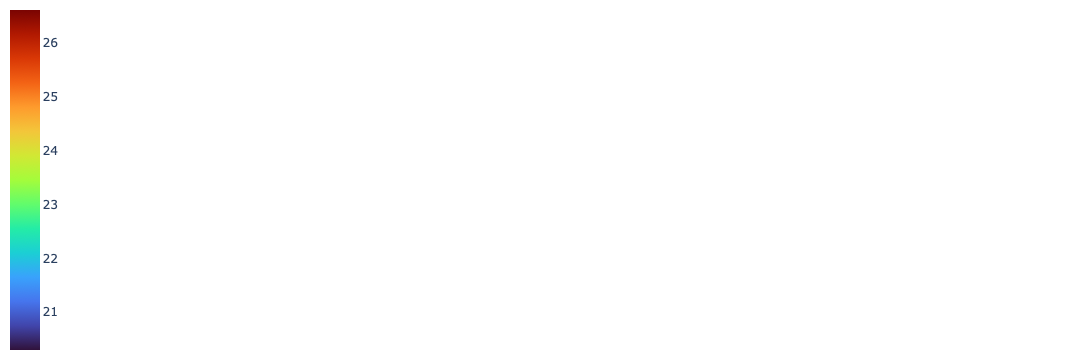

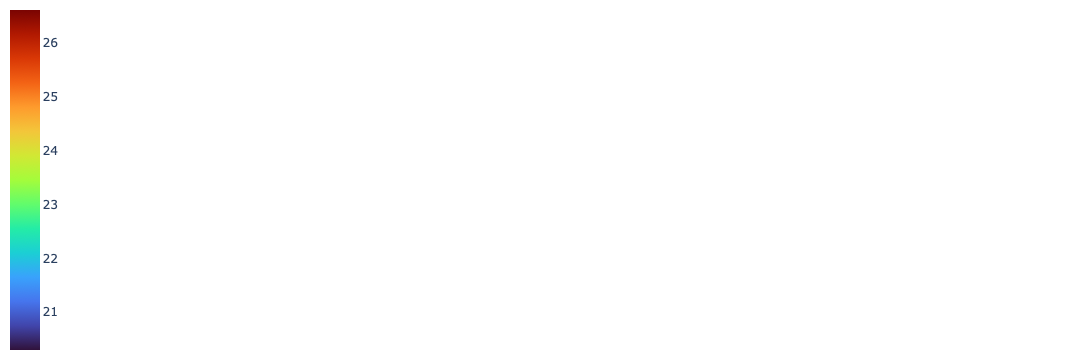

In [356]:
a = np.array([[min_temp, max_temp]])
fig = go.Figure(
    data=[
        go.Heatmap(
            z=a,
            colorscale="Turbo",
            showscale=True,
            zmin=a.min(),
            zmax=a.max(),
            colorbar=dict(x=0),
        ),
        go.Heatmap(
            z=np.zeros_like(a), # ensure there are enough points to cover the whole image
            colorscale="Picnic_r",  # any colorscale that has white at 0
            showscale=False,
            zmid=0,
        ),
    ],
)
fig.update_layout(
    width=75, # 75 seems to work empirically, you may have to adjust the width
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    xaxis_visible=False,
    yaxis_visible=False,
    margin=dict(l=0, r=0, b=0, t=0), # zeroing the margins gives a tighter figure, and is also important to make the other numbers work out
)
fig.show()

fig.update_traces(colorbar_orientation='v', selector=dict(type='heatmap'))

In [293]:
def plot_ei(avg_temp_df, side):

    colorscale = plotly.colors.sequential.Turbo

    fig = go.Figure()

    center = np.array([0, 0])
    polygon_center_xs = []
    polygon_center_ys = []
    chamber_names = []
    radius_inner = 1.0
    radius_outer = 8.0
    num_sections = 16
    num_eta = 8
    angular_offset = np.pi / num_sections + np.pi

    def get_vertex_coords(radius, angle, offset = 0):
        x = center[0] + (radius + offset) * np.cos(angle)
        y = center[1] + (radius + offset) * np.sin(angle)
        return [x, y]

    def get_polygon_vertices(ring_index, segment_index, offset = 0):
        start_angle = - 2 * np.pi * (segment_index - 1) / num_sections - angular_offset
        end_angle = - 2 * np.pi * (segment_index) / num_sections - angular_offset
        
        inner_radius = radius_inner + ring_index
        outer_radius = radius_inner + ring_index + 1

        v1 = get_vertex_coords(inner_radius, start_angle, offset)
        v2 = get_vertex_coords(inner_radius, end_angle, offset)
        v3 = get_vertex_coords(outer_radius, end_angle, offset)
        v4 = get_vertex_coords(outer_radius, start_angle, offset)
        
        return [v1, v2, v3, v4]

    # Draw the polygons
    for ring_index in range(num_eta):
        
        for segment_index in range(num_sections):
            
            # Get the chamber name
            if ring_index == 3:

                if segment_index % 2 == 0:

                    chamber_name = f'EIL{ring_index+1}{side}0{segment_index+1}'
                    chamber_names.append(chamber_name)

                    polygon_vertices = get_polygon_vertices(ring_index, segment_index)
            
                    # Calculate the polygon center
                    polygon_center_x = np.mean([v[0] for v in polygon_vertices])
                    polygon_center_y = np.mean([v[1] for v in polygon_vertices])

                    polygon_center_xs.append(polygon_center_x)
                    polygon_center_ys.append(polygon_center_y)

                    tmp_df = avg_temp_df[avg_temp_df['Chamber'].str.contains(chamber_name)]
                
                    # Choose the color based on tempurature
                    
                    if len(tmp_df) > 0:
    
                        avg_temp = tmp_df.iloc[0]['Average Temperature'].round(2)

                        if avg_temp == np.NaN:

                            fillcolor = 'red'
                            text = f'{chamber_name}: Faulty Chamber Sensors'

                        else:
                        
                            fillcolor = colorscale[get_color_from_temp(avg_temp, max_temp, min_temp)]
                            text = f'{chamber_name}: {avg_temp}'
                        
                    else:
                        
                        fillcolor = 'white'
                        text = f'{chamber_name}: No Data'
        
                    # Create the polygon
                    x_vals = [v[0] for v in polygon_vertices] + [polygon_vertices[0][0]]
                    y_vals = [v[1] for v in polygon_vertices] + [polygon_vertices[0][1]]
        
                    fig.add_trace(go.Scatter(
                        x=x_vals, y=y_vals,
                        mode = 'lines',
                        fill='toself',
                        fillcolor=fillcolor,
                        line=dict(color='black'),
                        hoverinfo='skip'
                    ))

                    fig.add_trace(go.Scatter(
                        x=[polygon_center_x], y=[polygon_center_y],
                        marker_color = fillcolor,
                        marker_size = 1,
                        name=chamber_name,
                        hoverinfo='text',
                        text=text,
                    ))
        
            elif ring_index > 5:

                if segment_index == 4:

                    if ring_index == 7:
                
                        chamber_name = f'EEL{ring_index+1-6}{side}0{segment_index+1}'
                        chamber_names.append(chamber_name)
        
                        polygon_vertices = get_polygon_vertices(ring_index, segment_index, offset = -.5)
                
                        # Calculate the polygon center
                        polygon_center_x = np.mean([v[0] for v in polygon_vertices])
                        polygon_center_y = np.mean([v[1] for v in polygon_vertices])

                        polygon_center_xs.append(polygon_center_x)
                        polygon_center_ys.append(polygon_center_y)
            
                        tmp_df = avg_temp_df[avg_temp_df['Chamber'].str.contains(chamber_name)]
                
                        # Choose the color based on tempurature
                        
                        if len(tmp_df) > 0:
        
                            avg_temp = tmp_df.iloc[0]['Average Temperature'].round(2)

                            if avg_temp == np.NaN:

                                fillcolor = 'red'
                                text = f'{chamber_name}: Faulty Chamber Sensors'

                            else:
                            
                                fillcolor = colorscale[get_color_from_temp(avg_temp, max_temp, min_temp)]
                                text = f'{chamber_name}: {avg_temp}'
                                
                        else:
                            
                            fillcolor = 'white'
                            text = f'{chamber_name}: No Data'
                
                            # Create the polygon
                            x_vals = [v[0] for v in polygon_vertices] + [polygon_vertices[0][0]]
                            y_vals = [v[1] for v in polygon_vertices] + [polygon_vertices[0][1]]
                
            
                        fig.add_trace(go.Scatter(
                            x=x_vals, y=y_vals,
                            mode = 'lines',
                            fill='toself',
                            fillcolor=fillcolor,
                            line=dict(color='black'),
                            hoverinfo='skip'
                        ))
                        fig.add_trace(go.Scatter(
                            x=[polygon_center_x], y=[polygon_center_y],
                            marker_color = fillcolor,
                            marker_size = 1,
                            name=chamber_name,
                            hoverinfo='text',
                            text=text,
                        ))
                
                else:

                    if segment_index % 2 == 0:

                        chamber_name = f'EEL{ring_index+1-6}{side}0{segment_index+1}'

                    else:

                        chamber_name = f'EES{ring_index+1-6}{side}0{segment_index+1}'
                        
                    chamber_names.append(chamber_name)
                    
                    polygon_vertices = get_polygon_vertices(ring_index, segment_index)
            
                    # Calculate the polygon center
                    polygon_center_x = np.mean([v[0] for v in polygon_vertices])
                    polygon_center_y = np.mean([v[1] for v in polygon_vertices])

                    polygon_center_xs.append(polygon_center_x)
                    polygon_center_ys.append(polygon_center_y)

                    # Choose the color based on temperature

                    tmp_df = avg_temp_df[avg_temp_df['Chamber'].str.contains(chamber_name)]
                                    
                    if len(tmp_df) > 0:
    
                        avg_temp = tmp_df.iloc[0]['Average Temperature'].round(2)

                        if avg_temp == np.NaN:

                            fillcolor = 'red'
                            text = f'{chamber_name}: Faulty Chamber Sensors'

                        else:
                        
                            fillcolor = colorscale[get_color_from_temp(avg_temp, max_temp, min_temp)]
                            text = f'{chamber_name}: {avg_temp}'
                        
                    else:
                        
                        fillcolor = 'white'
                        text = f'{chamber_name}: No Data'
        
                    # Create the polygon
                    x_vals = [v[0] for v in polygon_vertices] + [polygon_vertices[0][0]]
                    y_vals = [v[1] for v in polygon_vertices] + [polygon_vertices[0][1]]
        
        
                    fig.add_trace(go.Scatter(
                        x=x_vals, y=y_vals,
                        mode = 'lines',
                        fill='toself',
                        fillcolor=fillcolor,
                        line=dict(color='black'),
                        hoverinfo='skip'
                    ))

                    fig.add_trace(go.Scatter(
                        x=[polygon_center_x], y=[polygon_center_y],
                        marker_color = fillcolor,
                        marker_size = 1,
                        name=chamber_name,
                        hoverinfo='text',
                        text=text,
                    ))

    fig.update_layout(
    title = {
        'text': f'EI{side}',  # Set the title text
        'x': 0.5,  # Center the title horizontally (x=0.5 is the center of the plot)
        'y': .99,
        'xanchor': 'center',  # Anchors the title in the center
        'font': {
            'size': 40,  # Increase the font size
                }
        },
    showlegend=False,
    xaxis=dict(scaleanchor='y', showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=450, width=450,
    margin=dict(l=0,r=0,b=0,t=50)
    )

    return fig, chamber_names, polygon_center_xs, polygon_center_ys
    ber_names, polygon_center_xs, polygon_center_ys

In [294]:
# Draw EOC and EOA patterns
fig, chamber_names, polygon_center_xs, polygon_center_ys = plot_ei(avg_temp_df, 'C')

# Update the layout

fig.show()

In [295]:
tmp_df = pd.DataFrame(dict(chamber = chamber_names, x0 = polygon_center_xs, y0 = polygon_center_ys))

In [296]:
tmp_df['x0'] = tmp_df['x0'].round(2)
tmp_df['y0'] = tmp_df['y0'].round(2)

In [297]:
tmp_df

chamber    x0    y0
0    EIL4C01 -4.41  0.00
1    EIL4C03 -3.12  3.12
2    EIL4C05  0.00  4.41
3    EIL4C07  3.12  3.12
4    EIL4C09  4.41 -0.00
5   EIL4C011  3.12 -3.12
6   EIL4C013 -0.00 -4.41
7   EIL4C015 -3.12 -3.12
8    EEL1C01 -7.36  0.00
9    EES1C02 -6.80  2.81
10   EEL1C03 -5.20  5.20
11   EES1C04 -2.81  6.80
12   EES1C06  2.81  6.80
13   EEL1C07  5.20  5.20
14   EES1C08  6.80  2.81
15   EEL1C09  7.36 -0.00
16  EES1C010  6.80 -2.81
17  EEL1C011  5.20 -5.20
18  EES1C012  2.81 -6.80
19  EEL1C013 -0.00 -7.36
20  EES1C014 -2.81 -6.80
21  EEL1C015 -5.20 -5.20
22  EES1C016 -6.80 -2.81
23   EEL2C01 -8.34  0.00
24   EES2C02 -7.70  3.19
25   EEL2C03 -5.89  5.89
26   EES2C04 -3.19  7.70
27   EEL2C05  0.00  7.85
28   EES2C06  3.19  7.70
29   EEL2C07  5.89  5.89
30   EES2C08  7.70  3.19
31   EEL2C09  8.34 -0.00
32  EES2C010  7.70 -3.19
33  EEL2C011  5.89 -5.89
34  EES2C012  3.19 -7.70
35  EEL2C013 -0.00 -8.34
36  EES2C014 -3.19 -7.70
37  EEL2C015 -5.89 -5.89
38  EES2C016 -7.70 -3.19

In [298]:
# tmp_df.to_parquet('eic_coords.parquet')

In [299]:
# Draw EOC and EOA patterns
fig, chamber_names, polygon_center_xs, polygon_center_ys = plot_ei(avg_temp_df, 'A')
tmp_df = pd.DataFrame(dict(chamber = chamber_names, x0 = polygon_center_xs, y0 = polygon_center_ys))
fig.show()

In [300]:
tmp_df['x0'] = tmp_df['x0'].round(2)
tmp_df['y0'] = tmp_df['y0'].round(2)

In [301]:
tmp_df

chamber    x0    y0
0    EIL4A01 -4.41  0.00
1    EIL4A03 -3.12  3.12
2    EIL4A05  0.00  4.41
3    EIL4A07  3.12  3.12
4    EIL4A09  4.41 -0.00
5   EIL4A011  3.12 -3.12
6   EIL4A013 -0.00 -4.41
7   EIL4A015 -3.12 -3.12
8    EEL1A01 -7.36  0.00
9    EES1A02 -6.80  2.81
10   EEL1A03 -5.20  5.20
11   EES1A04 -2.81  6.80
12   EES1A06  2.81  6.80
13   EEL1A07  5.20  5.20
14   EES1A08  6.80  2.81
15   EEL1A09  7.36 -0.00
16  EES1A010  6.80 -2.81
17  EEL1A011  5.20 -5.20
18  EES1A012  2.81 -6.80
19  EEL1A013 -0.00 -7.36
20  EES1A014 -2.81 -6.80
21  EEL1A015 -5.20 -5.20
22  EES1A016 -6.80 -2.81
23   EEL2A01 -8.34  0.00
24   EES2A02 -7.70  3.19
25   EEL2A03 -5.89  5.89
26   EES2A04 -3.19  7.70
27   EEL2A05  0.00  7.85
28   EES2A06  3.19  7.70
29   EEL2A07  5.89  5.89
30   EES2A08  7.70  3.19
31   EEL2A09  8.34 -0.00
32  EES2A010  7.70 -3.19
33  EEL2A011  5.89 -5.89
34  EES2A012  3.19 -7.70
35  EEL2A013 -0.00 -8.34
36  EES2A014 -3.19 -7.70
37  EEL2A015 -5.89 -5.89
38  EES2A016 -7.70 -3.19

In [302]:
# tmp_df.to_parquet('eia_coords.parquet')

In [303]:
def plot_em(fsm_df, side):

    colorscale = plotly.colors.sequential.Turbo
    
    fig = go.Figure()
    
    center = np.array([0, 0])
    polygon_center_xs = []
    polygon_center_ys = []
    chamber_names = []
    radius_inner = 1.0
    radius_outer = 5.0
    num_sections = 16
    num_eta = 5
    angular_offset = np.pi / num_sections + np.pi

    def get_vertex_coords(radius, angle, offset = 0):
        x = center[0] + (radius + offset) * np.cos(angle)
        y = center[1] + (radius + offset) * np.sin(angle)
        return [x, y]

    def get_polygon_vertices(ring_index, segment_index, offset = 0):
        start_angle = - 2 * np.pi * (segment_index - 1) / num_sections - angular_offset
        end_angle = - 2 * np.pi * (segment_index) / num_sections - angular_offset
        
        inner_radius = radius_inner + ring_index
        outer_radius = radius_inner + ring_index + 1

        v1 = get_vertex_coords(inner_radius, start_angle, offset)
        v2 = get_vertex_coords(inner_radius, end_angle, offset)
        v3 = get_vertex_coords(outer_radius, end_angle, offset)
        v4 = get_vertex_coords(outer_radius, start_angle, offset)
        
        return [v1, v2, v3, v4]

    # Draw the polygons
    for ring_index in range(num_eta):
        
        for segment_index in range(num_sections):

            polygon_vertices = get_polygon_vertices(ring_index, segment_index)
            
            # Calculate the polygon center
            polygon_center_x = np.mean([v[0] for v in polygon_vertices])
            polygon_center_y = np.mean([v[1] for v in polygon_vertices])

            polygon_center_xs.append(polygon_center_x)
            polygon_center_ys.append(polygon_center_y)

            # Get the chamber name
            if segment_index < 10:

                if segment_index % 2 != 0:
                    
                    chamber_name = f'EMS{ring_index+1}{side}0{segment_index+1}'

                else:

                    chamber_name = f'EML{ring_index+1}{side}0{segment_index+1}'

            else:
                
                if segment_index % 2 != 0:
                    
                    chamber_name = f'EMS{ring_index+1}{side}{segment_index+1}'

                else:

                    chamber_name = f'EML{ring_index+1}{side}{segment_index+1}'

            chamber_names.append(chamber_name)
                    
            tmp_df = avg_temp_df[avg_temp_df['Chamber'].str.contains(chamber_name)]
    
            # Choose the color based on tempurature
            
            if len(tmp_df) > 0:

                avg_temp = tmp_df.iloc[0]['Average Temperature'].round(2)
                
                if avg_temp == np.NaN:
    
                    fillcolor = 'red'
                    text = f'{chamber_name}: Faulty Chamber Sensors'
    
                else:
                
                    fillcolor = colorscale[get_color_from_temp(avg_temp, max_temp, min_temp)]
                    text = f'{chamber_name}: {avg_temp}'
                
            else:
                
                fillcolor = 'white'
                text = f'{chamber_name}: No Data'

            # Create the polygon
            x_vals = [v[0] for v in polygon_vertices] + [polygon_vertices[0][0]]
            y_vals = [v[1] for v in polygon_vertices] + [polygon_vertices[0][1]]

            fig.add_trace(go.Scatter(
                x=x_vals, y=y_vals,
                mode = 'lines',
                fill='toself',
                fillcolor=fillcolor,
                line=dict(color='black'),
                hoverinfo='skip'
            ))

            fig.add_trace(go.Scatter(
                x=[polygon_center_x], y=[polygon_center_y],
                marker_color = fillcolor,
                marker_size = 1,
                name=chamber_name,
                hoverinfo='text',
                text=text,
            ))

    # Update the layout
    fig.update_layout(
    title = {
        'text': f'EM{side}',  # Set the title text
        'x': 0.5,  # Center the title horizontally (x=0.5 is the center of the plot)
        'y': .99,
        'xanchor': 'center',  # Anchors the title in the center
        'font': {
            'size': 40,  # Increase the font size
                }
        },
    showlegend=False,
    xaxis=dict(scaleanchor='y', showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=450, width=450,
    margin=dict(l=0,r=0,b=0,t=50)
    )

    return fig, chamber_names, polygon_center_xs, polygon_center_ys

In [304]:
# Draw EOC and EOA patterns
fig, chamber_names, polygon_center_xs, polygon_center_ys = plot_em(avg_temp_df, 'C')
tmp_df = pd.DataFrame(dict(chamber = chamber_names, x0 = polygon_center_xs, y0 = polygon_center_ys))
fig.show()

In [305]:
tmp_df['x0'] = tmp_df['x0'].round(2)
tmp_df['y0'] = tmp_df['y0'].round(2)

In [306]:
tmp_df

chamber    x0    y0
0   EML1C01 -1.47  0.00
1   EMS1C02 -1.36  0.56
2   EML1C03 -1.04  1.04
3   EMS1C04 -0.56  1.36
4   EML1C05  0.00  1.47
..      ...   ...   ...
75  EMS5C12  2.06 -4.98
76  EML5C13 -0.00 -5.39
77  EMS5C14 -2.06 -4.98
78  EML5C15 -3.81 -3.81
79  EMS5C16 -4.98 -2.06

[80 rows x 3 columns]

In [307]:
# tmp_df.to_parquet('emc_coords.parquet')

In [308]:
# Draw EOC and EOA patterns
fig, chamber_names, polygon_center_xs, polygon_center_ys = plot_em(avg_temp_df, 'A')
tmp_df = pd.DataFrame(dict(chamber = chamber_names, x0 = polygon_center_xs, y0 = polygon_center_ys))
fig.show()

In [309]:
tmp_df['x0'] = tmp_df['x0'].round(2)
tmp_df['y0'] = tmp_df['y0'].round(2)

In [310]:
# tmp_df.to_parquet('ema_coords.parquet')

In [311]:
def plot_eo(fsm_df, side):

    colorscale = plotly.colors.sequential.Turbo

    fig = go.Figure()
    
    center = np.array([0, 0])
    polygon_center_xs = []
    polygon_center_ys = []
    chamber_names = []
    radius_inner = 1.0
    radius_outer = 6.0
    num_sections = 16
    num_eta = 6
    angular_offset = np.pi / num_sections + np.pi

    def get_vertex_coords(radius, angle, offset = 0):
        x = center[0] + (radius + offset) * np.cos(angle)
        y = center[1] + (radius + offset) * np.sin(angle)
        return [x, y]

    def get_polygon_vertices(ring_index, segment_index, offset = 0):
        start_angle = - 2 * np.pi * (segment_index - 1) / num_sections - angular_offset
        end_angle = - 2 * np.pi * (segment_index) / num_sections - angular_offset
        
        inner_radius = radius_inner + ring_index
        outer_radius = radius_inner + ring_index + 1

        v1 = get_vertex_coords(inner_radius, start_angle, offset)
        v2 = get_vertex_coords(inner_radius, end_angle, offset)
        v3 = get_vertex_coords(outer_radius, end_angle, offset)
        v4 = get_vertex_coords(outer_radius, start_angle, offset)

    def get_polygon_vertices(ring_index, segment_index):
        start_angle = - 2 * np.pi * (segment_index - 1) / num_sections - angular_offset
        end_angle = - 2 * np.pi * (segment_index) / num_sections - angular_offset
        
        inner_radius = radius_inner + ring_index
        outer_radius = radius_inner + ring_index + 1

        v1 = get_vertex_coords(inner_radius, start_angle)
        v2 = get_vertex_coords(inner_radius, end_angle)
        v3 = get_vertex_coords(outer_radius, end_angle)
        v4 = get_vertex_coords(outer_radius, start_angle)
        
        return [v1, v2, v3, v4]

    # Draw the polygons
    for ring_index in range(num_eta):
        
        for segment_index in range(num_sections):
            
            polygon_vertices = get_polygon_vertices(ring_index, segment_index)
            
            # Calculate the polygon center
            polygon_center_x = np.mean([v[0] for v in polygon_vertices])
            polygon_center_y = np.mean([v[1] for v in polygon_vertices])

            polygon_center_xs.append(polygon_center_x)
            polygon_center_ys.append(polygon_center_y)

            # Get the chamber name
            if segment_index < 10:

                if segment_index % 2 != 0:
                    
                    chamber_name = f'EOS{ring_index+1}{side}0{segment_index+1}'

                else:

                    chamber_name = f'EOL{ring_index+1}{side}0{segment_index+1}'

            else:
                
                if segment_index % 2 != 0:
                    
                    chamber_name = f'EOS{ring_index+1}{side}{segment_index+1}'

                else:

                    chamber_name = f'EOL{ring_index+1}{side}{segment_index+1}'

            chamber_names.append(chamber_name)

            tmp_df = avg_temp_df[avg_temp_df['Chamber'].str.contains(chamber_name)]
    
            # Choose the color based on tempurature
            
            if len(tmp_df) > 0:

                avg_temp = tmp_df.iloc[0]['Average Temperature'].round(2)
                
                if avg_temp == np.NaN:

                    fillcolor = 'red'
                    text = f'{chamber_name}: Faulty Chamber Sensors'

                else:
                
                    fillcolor = colorscale[get_color_from_temp(avg_temp, max_temp, min_temp)]
                    text = f'{chamber_name}: {avg_temp}'
                
            else:
                
                fillcolor = 'white'
                text = f'{chamber_name}: No Data'

            # Create the polygon
            x_vals = [v[0] for v in polygon_vertices] + [polygon_vertices[0][0]]
            y_vals = [v[1] for v in polygon_vertices] + [polygon_vertices[0][1]]

            fig.add_trace(go.Scatter(
                x=x_vals, y=y_vals,
                mode = 'lines',
                fill='toself',
                fillcolor=fillcolor,
                line=dict(color='black'),
                hoverinfo='skip'
            ))

            fig.add_trace(go.Scatter(
                x=[polygon_center_x], y=[polygon_center_y],
                marker_color = fillcolor,
                marker_size = 1,
                name=chamber_name,
                hoverinfo='text',
                text=text,
            ))

    # Update the layout
    fig.update_layout(
    title = {
        'text': f'EO{side}',  # Set the title text
        'x': 0.5,  # Center the title horizontally (x=0.5 is the center of the plot)
        'y': .99,
        'xanchor': 'center',  # Anchors the title in the center
        'font': {
            'size': 40,  # Increase the font size
                }
        },
    showlegend=False,
    xaxis=dict(scaleanchor='y', showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=450, width=450,
    margin=dict(l=0,r=0,b=0,t=50)
    )

    return fig, chamber_names, polygon_center_xs, polygon_center_ys

In [312]:
# Draw EOC and EOA patterns
fig, chamber_names, polygon_center_xs, polygon_center_ys = plot_eo(avg_temp_df, 'C')
tmp_df = pd.DataFrame(dict(chamber = chamber_names, x0 = polygon_center_xs, y0 = polygon_center_ys))
fig.show()

In [313]:
tmp_df['x0'] = tmp_df['x0'].round(2)
tmp_df['y0'] = tmp_df['y0'].round(2)

In [314]:
tmp_df

chamber    x0    y0
0   EOL1C01 -1.47  0.00
1   EOS1C02 -1.36  0.56
2   EOL1C03 -1.04  1.04
3   EOS1C04 -0.56  1.36
4   EOL1C05  0.00  1.47
..      ...   ...   ...
91  EOS6C12  2.44 -5.89
92  EOL6C13 -0.00 -6.38
93  EOS6C14 -2.44 -5.89
94  EOL6C15 -4.51 -4.51
95  EOS6C16 -5.89 -2.44

[96 rows x 3 columns]

In [315]:
# tmp_df.to_parquet('eoc_coords.parquet')

In [316]:
# Draw EOC and EOA patterns
fig, chamber_names, polygon_center_xs, polygon_center_ys = plot_eo(avg_temp_df, 'A')
tmp_df = pd.DataFrame(dict(chamber = chamber_names, x0 = polygon_center_xs, y0 = polygon_center_ys))
fig.show()

In [317]:
tmp_df['x0'] = tmp_df['x0'].round(2)
tmp_df['y0'] = tmp_df['y0'].round(2)

In [318]:
def plot_be_bi_test(xs_ys_df, avg_temp_df):

    colorscale = plotly.colors.sequential.Turbo
    
    xs_list = []
    ys_list = []
    
    fig = go.Figure()
    
    box_size = 10
    
    for x0, y0, chamber_name in zip(xs_ys_df['x0'].astype(int), xs_ys_df['y0'].astype(int), xs_ys_df['chamber']):
        
        # Get the chamber name
    
        tmp_df = avg_temp_df[avg_temp_df['Chamber'].str.contains(chamber_name)]

        # Choose the color based on tempurature
        
        if len(tmp_df) > 0:

            avg_temp = tmp_df.iloc[0]['Average Temperature'].round(2)
            
            if avg_temp == np.NaN:

                fillcolor = 'red'
                text = f'{chamber_name}: Faulty Chamber Sensors'

            else:
            
                fillcolor = colorscale[get_color_from_temp(avg_temp, max_temp, min_temp)]
                text = f'{chamber_name}: {avg_temp}'
            
        else:
            
            fillcolor = 'white'
            text = f'{chamber_name}: No Data'
    
        xs = [x0, x0+box_size, x0+box_size, x0, x0]
        ys = [y0, y0, y0 + box_size, y0 + box_size, y0]
        xs_list.append(y0)
        ys_list.append(-x0 + 300)
    
        fig.add_trace(go.Scatter(
            x=xs, y=ys,
            mode = 'lines',
            fill='toself',
            fillcolor=fillcolor,
            line=dict(color='black'),
            name=chamber_name,
            hoverinfo='text',
            text=text
        ))
    
    fig.update_layout(
    title = {
        'text': 'BE/BI',  # Set the title text
        'x': 0.5,  # Center the title horizontally (x=0.5 is the center of the plot)
        'y': .99,
        'xanchor': 'center',  # Anchors the title in the center
        'font': {
            'size': 40,  # Increase the font size
                }
        },
    showlegend=False,
    xaxis=dict(scaleanchor='y', showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=1000, width=1000,
    margin=dict(l=0,r=0,b=0,t=0)
    )
        
    return fig

In [319]:
coords_df = pd.read_parquet('mappings/be_bi_coords.parquet')

fig = plot_be_bi_test(coords_df, avg_temp_df)
fig.show()

In [320]:
def plot_bm_test(xs_ys_df, avg):

    colorscale = plotly.colors.sequential.Turbo
    
    xs_list = []
    ys_list = []
    
    fig = go.Figure()
    
    box_size = 10
    
    for x0, y0, chamber_name in zip(xs_ys_df['x0'].astype(int), xs_ys_df['y0'].astype(int), xs_ys_df['chamber']):
        
        # Get the chamber name
    
        tmp_df = avg_temp_df[avg_temp_df['Chamber'].str.contains(chamber_name)]

        # Choose the color based on tempurature
        
        if len(tmp_df) > 0:

            avg_temp = tmp_df.iloc[0]['Average Temperature'].round(2)
            
            if np.isnan(avg_temp):

                fillcolor = 'red'
                text = f'{chamber_name}: Faulty Chamber Sensors'

            else:
            
                fillcolor = colorscale[get_color_from_temp(avg_temp, max_temp, min_temp)]
                text = f'{chamber_name}: {avg_temp}'
            
        else:
            
            fillcolor = 'white'
            text = f'{chamber_name}: No Data'
            
        xs = [x0, x0+box_size, x0+box_size, x0, x0]
        ys = [y0, y0, y0 + box_size, y0 + box_size, y0]
    
        fig.add_trace(go.Scatter(
            x=xs, y=ys,
            mode = 'lines',
            fill='toself',
            fillcolor=fillcolor,
            line=dict(color='black'),
            name=chamber_name,
            hoverinfo='text',
            text=text
        ))
    
    fig.update_layout(
    title = {
        'text': 'BM',  # Set the title text
        'x': 0.5,  # Center the title horizontally (x=0.5 is the center of the plot)
        'y': .99,
        'xanchor': 'center',  # Anchors the title in the center
        'font': {
            'size': 40,  # Increase the font size
                }
        },
    showlegend=False,
    xaxis=dict(range=[-90, 90], scaleanchor='y', showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(range=[-142, 130], showgrid=False, zeroline=False, showticklabels=False),
    height=1000, width=1000,
    margin=dict(l=0,r=0,b=0,t=0)
    )
        
    return fig

In [321]:
coords_df = pd.read_parquet('mappings/bm_coords.parquet')

fig = plot_bm_test(coords_df, avg_temp_df)
fig.show()

In [322]:
def plot_bo_test(xs_ys_df, avg_temp_df):
    
    colorscale = plotly.colors.sequential.Turbo

    xs_list = []
    ys_list = []
    
    fig = go.Figure()
    
    box_size = 10
    
    for x0, y0, chamber_name in zip(xs_ys_df['x0'].astype(int), xs_ys_df['y0'].astype(int), xs_ys_df['chamber']):
        
        # Get the chamber name
    
        tmp_df = avg_temp_df[avg_temp_df['Chamber'].str.contains(chamber_name)]

        # Choose the color based on tempurature
        
        if len(tmp_df) > 0:

            avg_temp = tmp_df.iloc[0]['Average Temperature'].round(2)
            
            if np.isnan(avg_temp):

                fillcolor = 'red'
                text = f'{chamber_name}: Faulty Chamber Sensors'

            else:
            
                fillcolor = colorscale[get_color_from_temp(avg_temp, max_temp, min_temp)]
                text = f'{chamber_name}: {avg_temp}'
            
        else:
            
            fillcolor = 'white'
            text = f'{chamber_name}: No Data'
    
        xs = [x0, x0+box_size, x0+box_size, x0, x0]
        ys = [y0, y0, y0 + box_size, y0 + box_size, y0]
    
        fig.add_trace(go.Scatter(
            x=xs, y=ys,
            mode = 'lines',
            fill='toself',
            fillcolor=fillcolor,
            line=dict(color='black'),
            name=chamber_name,
            hoverinfo='text',
            text=text
        ))

    fig.update_layout(
    title = {
        'text': 'BO',  # Set the title text
        'x': 0.5,  # Center the title horizontally (x=0.5 is the center of the plot)
        'y': .99,
        'xanchor': 'center',  # Anchors the title in the center
        'font': {
            'size': 40,  # Increase the font size
                }
        },
    showlegend=False,
    xaxis=dict(range=[-110, 110], scaleanchor='y', showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(range=[-130, 138], showgrid=False, zeroline=False, showticklabels=False),
    height=1000, width=1000,
    margin=dict(l=0,r=0,b=0,t=0)
    )
        
    return fig

In [323]:
coords_df = pd.read_parquet('mappings/bo_coords.parquet')

fig = plot_bo_test(coords_df, avg_temp_df)
fig.show()